# Analisis de datos (Spotify)
---
Este notebook contiene un analisis de los datos obtenidos en el API de spotify, donde nuestro objetivo del analisis es:


# 1. Cargamos las bibliotecas necesarias para la ejecucion del programa

In [ ]:
# bibliotecas
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler #cargamos los paquetes necesarios para poder normalizar o estandarizar
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

#2. Cargamos el Dataset
Cargamos los datos almacenados en un archivo XLSX previamente obtenido, los cuales ya han sido sometidos a un proceso de limpieza para eliminar registros duplicados. Este conjunto de datos contiene varias columnas que representan lo siguiente:

1. **Nombre:** Titulo de la canción.

2. **Bailabilidad:** Una métrica que indica qué tan apta es una canción para bailar, basada en características como tempo, estabilidad del ritmo y regularidad. Los valores van de 0 (menos bailable) a 1 (más bailable).

3. **Energía:** Representa la intensidad y actividad percibida en la canción. Las canciones con mayor energía tienden a sentirse rápidas y ruidosas. Valores de 0 a 1.

4. **Acústica:** Mide que tan acústica es una canción, 1 indica una alta presencia de elementos acústicos y 0 indica la producción completamente digital o electrónica.

5. **Duración (Ms):** Duración total de la canción en milisegundos.

6. **Instrumentalidad:** Indica la probabilidad de que la canción sea instrumental (sin voces). Valores cercanos a 1 indican mayor probabilidad de que no haya voces.

7. **Sonoridad:** El nivel general de volumen percibido en la canción, medido en decibeles (dB). Valores negativos más bajos indican canciones más suaves, mientras que valores más altos indican canciones más fuertes.

8. **Tempo:** El ritmo o velocidad de la canción, medido en pulsaciones por minuto (BPM).

9. **Discursividad:** Mide qué tan hablada es la canción. Valores altos indican mayor presencia de palabras habladas, como en un podcast o rap.

10. **ID:** Identificador único de la canción generado por Spotify.

11. **Modo:** Representa si la canción está en modo mayor o menor:

    1: Modo mayor (asociado con canciones alegres).

    0: Modo menor (asociado con canciones más melancólicas).

12. **Valencia:** Mide el grado de positividad o felicidad percibida en la canción. Valores cercanos a 1 indican canciones felices, y valores cercanos a 0 indican canciones más tristes o sombrías.

13. **Género:** La categoría musical o estilo al que pertenece la canción



In [ ]:
#cargamos el dataset
dataset_path = 'spotify_sin_duplicados.xlsx'
data = pd.read_excel(dataset_path)
print(data)

                             Nombre  Bailabilidad  Energía  Acústica  \
0                          In Death         0.551    0.965  0.000124   
1                Soulless Existence         0.414    0.930  0.000008   
2                  Nymphetamine Fix         0.462    0.905  0.000660   
3    ...And I Return to Nothingness         0.392    0.922  0.000031   
4                     Freezing Moon         0.168    0.974  0.000030   
..                              ...           ...      ...       ...   
480                        TOGETHER         0.389    0.786  0.216000   
481          Touch Of Heaven - Live         0.400    0.437  0.134000   
482                Who You Say I Am         0.368    0.654  0.005180   
483        Jesus Have It All - Live         0.453    0.373  0.821000   
484    Oceans (Where Feet May Fail)         0.262    0.361  0.509000   

     Duración (ms)  Instrumentalidad  Sonoridad    Tempo  Discursividad  \
0           134560          0.710000     -4.852  115.003    

## 3. Preparar datos
El objetivo de esta etapa es preparar los datos para análisis, esta etapa incluye tareas como la conversión de formatos, el manejo de valores faltantes y la estandarización y normalización.

In [ ]:
#mostramos las estadísticas descriptivas de las columnas numéricas
print("\nEstadísticas descriptivas de las columnas numéricas:")
print(data.describe())

#calculamos los umbrales basados en los datos
columnas_numericas = data.select_dtypes(include=['float64', 'int64']).columns
umbral_rango = data[columnas_numericas].max().mean() - data[columnas_numericas].min().mean()
umbral_desviacion = data[columnas_numericas].std().mean()

print("\nUmbrales calculados automáticamente:")
print(f"Umbral para rango: {umbral_rango}")
print(f"Umbral para desviación estándar: {umbral_desviacion}")

# Evaluar la necesidad de normalizar o estandarizar
print("\nEvaluando la necesidad de normalizar o estandarizar:")
for col in columnas_numericas:
    rango = data[col].max() - data[col].min()
    desviacion = data[col].std()
    print(f"\nColumna: {col}")
    print(f"Rango: {rango}, Desviación estándar: {desviacion}")

    if rango > umbral_rango or desviacion > umbral_desviacion:
        print(f"-> Recomendación: {col} podría beneficiarse de la normalización.")
    else:
        print(f"-> Recomendación: {col} podría beneficiarse de la estandarización.")



Estadísticas descriptivas de las columnas numéricas:
       Bailabilidad     Energía    Acústica  Duración (ms)  Instrumentalidad  \
count    485.000000  485.000000  485.000000     485.000000        485.000000   
mean       0.605590    0.666685    0.232123  225418.334021          0.083948   
std        0.181159    0.187910    0.258165   77618.613346          0.232312   
min        0.160000    0.022300    0.000002   69747.000000          0.000000   
25%        0.471000    0.551000    0.017200  172533.000000          0.000000   
50%        0.636000    0.701000    0.126000  210347.000000          0.000008   
75%        0.752000    0.799000    0.391000  265133.000000          0.001510   
max        0.943000    0.990000    0.996000  568787.000000          0.965000   

        Sonoridad       Tempo  Discursividad        Modo    Valencia  
count  485.000000  485.000000     485.000000  485.000000  485.000000  
mean    -6.749507  118.143272       0.076071    0.587629    0.501546  
std      3.2

**Estandarización recomendada de columnas**

In [ ]:
for columna in columnas_numericas:
    # Guardar los datos originales antes de la transformación
    datos_originales = data[columna].values.copy()
    RIQ = data[columna].quantile(0.75) - data[columna].quantile(0.25)
    des_std = data[columna].std()

    if RIQ < 1.5 * des_std:
        print("Nos conviene normalizar")
        escalamiento = MinMaxScaler()
        datos_transformados = escalamiento.fit_transform(data[columna].values.reshape(-1, 1))
    else:
        print("Nos conviene estandarizar")
        escalamiento = StandardScaler()
        datos_transformados = escalamiento.fit_transform(data[columna].values.reshape(-1, 1))

    # Guardar los datos transformados en el DataFrame
    data[columna] = datos_transformados.flatten()

# Exportar los datos a un archivo Excel
data.to_excel('spotify_datos_escalados.xlsx', index=False)
print("Datos escalados exportados a spotify_datos_escalados.xlsx")

Nos conviene estandarizar
Nos conviene normalizar
Nos conviene normalizar
Nos conviene normalizar
Nos conviene normalizar
Nos conviene normalizar
Nos conviene normalizar
Nos conviene normalizar
Nos conviene estandarizar
Nos conviene estandarizar
Datos escalados exportados a spotify_datos_escalados.xlsx


## Cálculo de Estadísticas Básicas
Las estadísticas descriptivas nos dan una idea general de los datos, como la tendencia central y la dispersión.

In [ ]:
#funcion para calcular estadísticas según el tipo de datos
for column in data.columns:
    print(f"\nEstadísticas para la columna: {column}")
    if data[column].dtype in ['int64', 'float64']:  #si la columna es numérica
        promedio = data[column].mean()
        mediana = data[column].median()
        moda = data[column].mode()[0]
        varianza = data[column].var()
        desviacion = data[column].std()
        rango = data[column].max() - data[column].min()
        print(f"  Promedio: {promedio}")
        print(f"  Mediana: {mediana}")
        print(f"  Moda: {moda}")
        print(f"  Varianza: {varianza}")
        print(f"  Desviación estándar: {desviacion}")
        print(f"  Rango: {rango}")
    elif data[column].dtype == 'object':  #si la columna es categórica o de texto
        valores_unicos = data[column].nunique()
        print(f"  Número de valores únicos: {valores_unicos}")
        print(f"  Valores únicos: {data[column].unique()[:5]}...")  #mostramos solo los primeros 5
    elif data[column].dtype == 'datetime64[ns]':  #si es fecha
        print(f"  Rango de fechas: {data[column].min()} - {data[column].max()}")
    else:
        print(f"  Tipo de dato no manejado: {data[column].dtype}")



Estadísticas para la columna: Nombre
  Número de valores únicos: 464
  Valores únicos: ['In Death' 'Soulless Existence' 'Nymphetamine Fix'
 '...And I Return to Nothingness' 'Freezing Moon']...

Estadísticas para la columna: Bailabilidad
  Promedio: 2.9300731371550524e-17
  Mediana: 0.16803829887342112
  Moda: 0.3006551406177172
  Varianza: 1.0020661157024782
  Desviación estándar: 1.0010325247975103
  Rango: 4.326624461907654

Estadísticas para la columna: Energía
  Promedio: 0.66589330211182
  Mediana: 0.7013537253280975
  Moda: 0.7592228996589853
  Varianza: 0.03770661981673026
  Desviación estándar: 0.19418192453658054
  Rango: 0.9999999999999999

Estadísticas para la columna: Acústica
  Promedio: 0.23305407886565305
  Mediana: 0.1265047085914286
  Moda: 0.00290010476923409
  Varianza: 0.06718603348634494
  Desviación estándar: 0.2592026880384248
  Rango: 1.0

Estadísticas para la columna: Duración (ms)
  Promedio: 0.3119415959053755
  Mediana: 0.28174094260981086
  Moda: 0.2026711

# Visualización

El siguiente código tiene como objetivo generar visualizaciones exploratorias para todas las columnas de un conjunto de datos, adaptándose al tipo de datos que contiene cada columna. Esto permite analizar visualmente la distribución, frecuencia y patrones de los datos, facilitando su interpretación y comprensión.



Generando visualizaciones para la columna: Nombre
  La columna Nombre tiene demasiados valores únicos para un gráfico de barras.

Generando visualizaciones para la columna: Bailabilidad


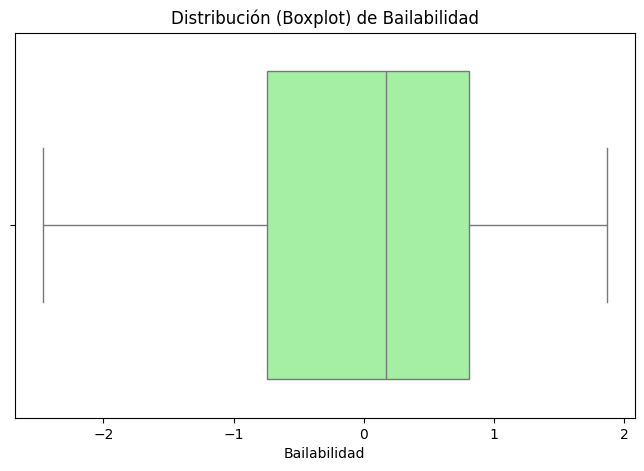

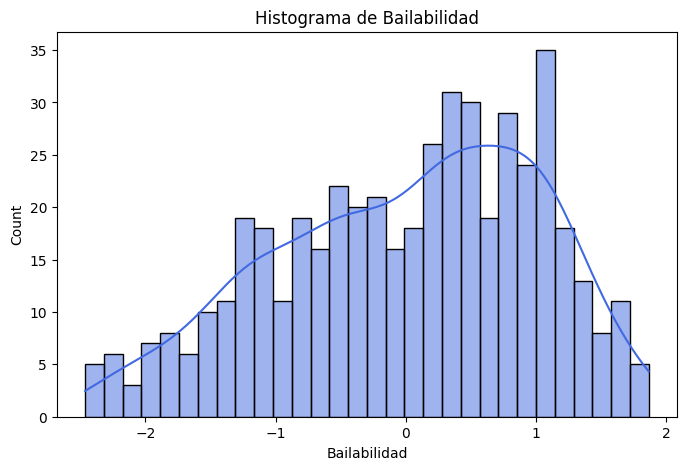


Generando visualizaciones para la columna: Energía


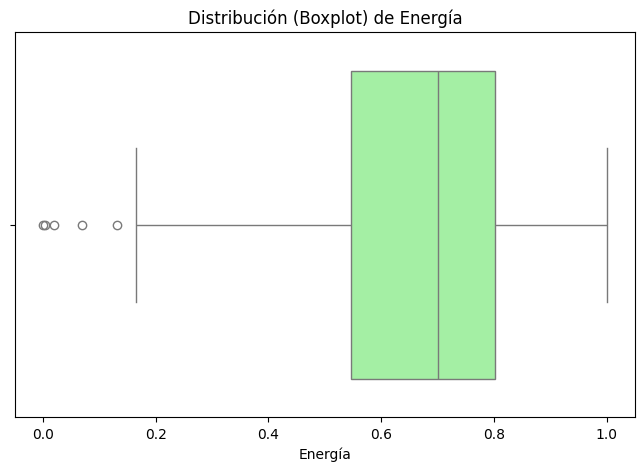

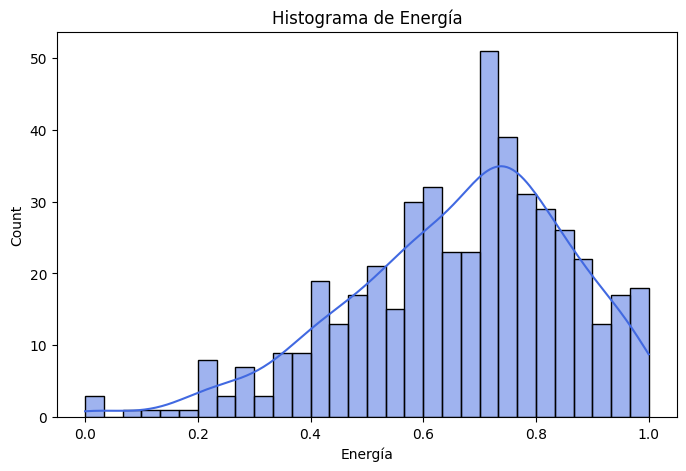


Generando visualizaciones para la columna: Acústica


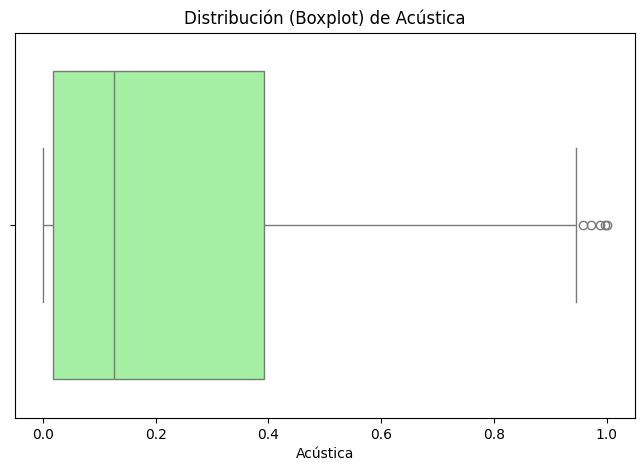

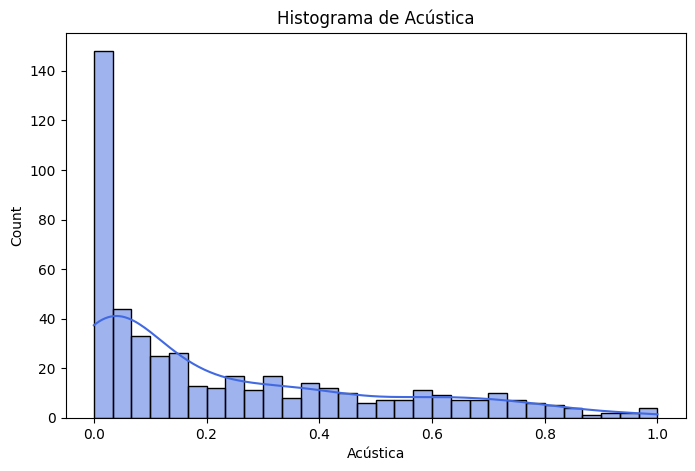


Generando visualizaciones para la columna: Duración (ms)


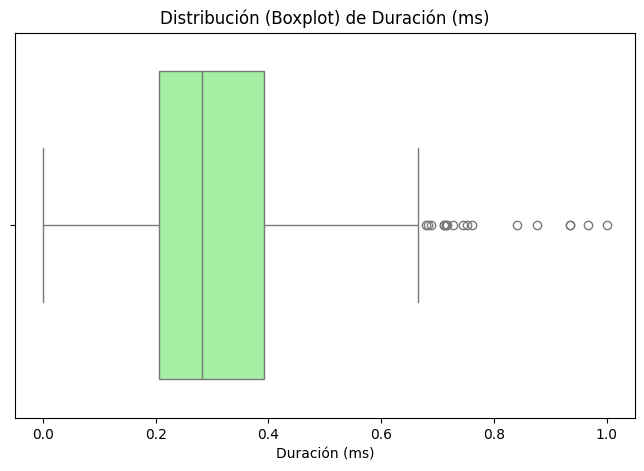

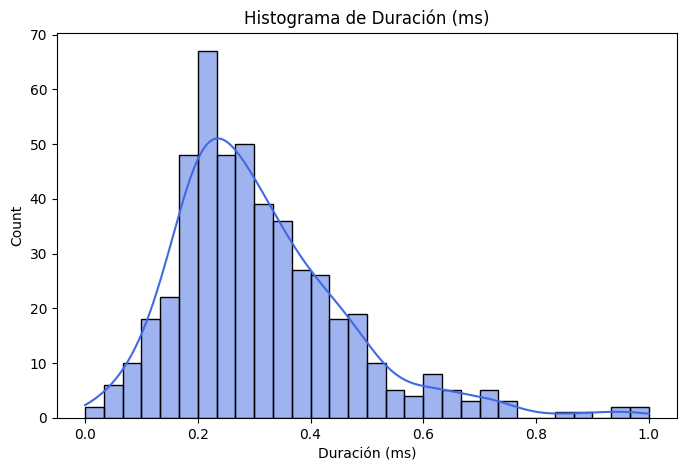


Generando visualizaciones para la columna: Instrumentalidad


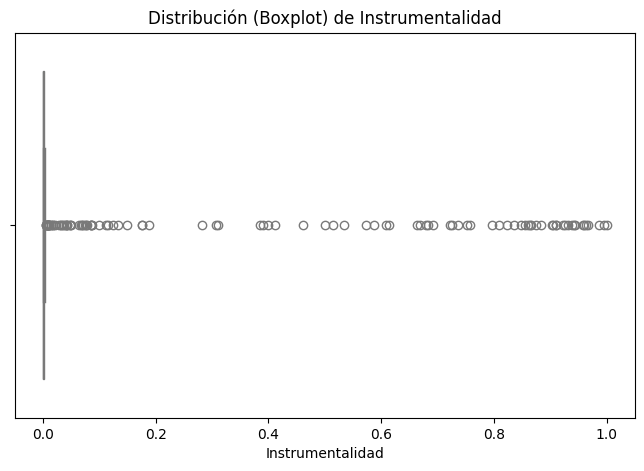

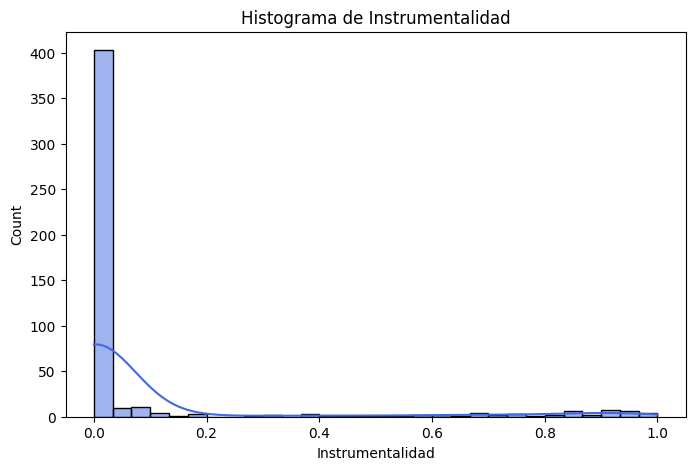


Generando visualizaciones para la columna: Sonoridad


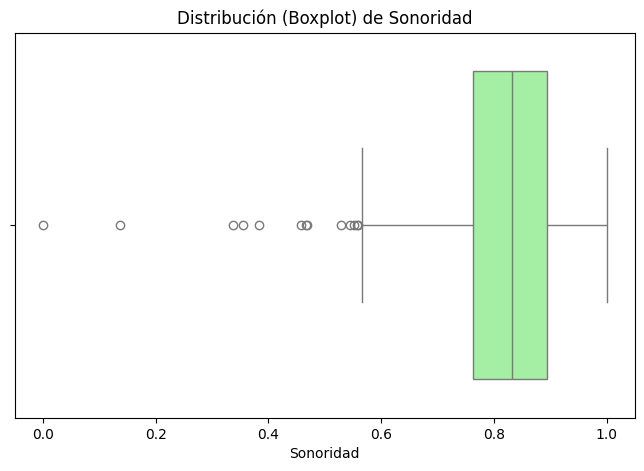

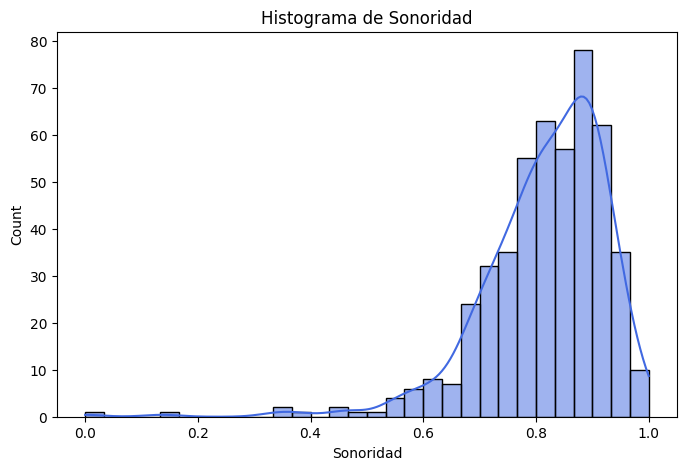


Generando visualizaciones para la columna: Tempo


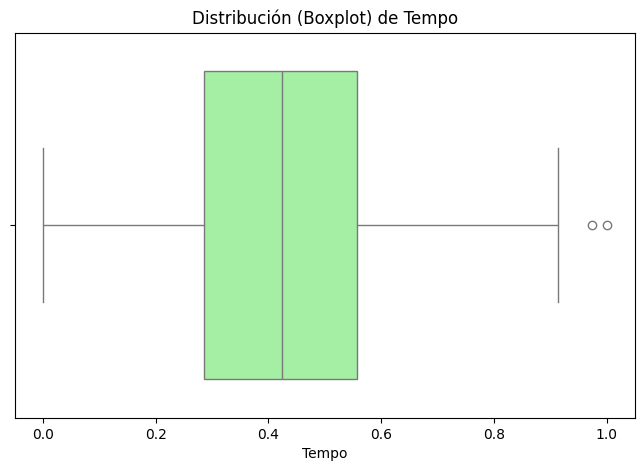

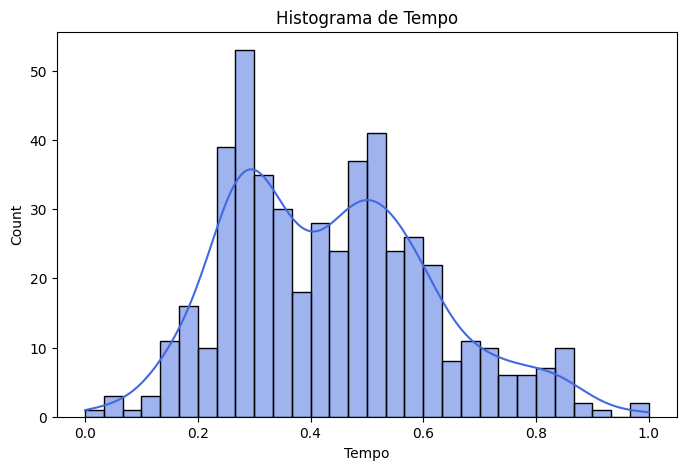


Generando visualizaciones para la columna: Discursividad


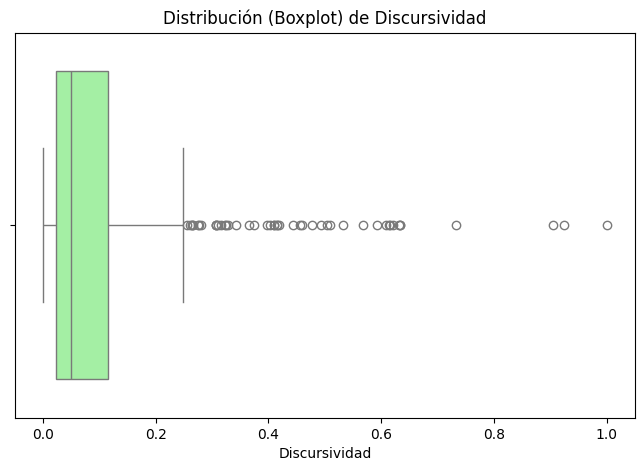

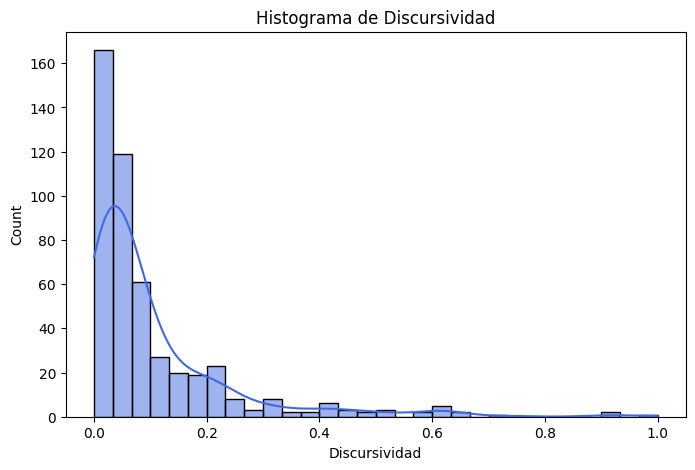


Generando visualizaciones para la columna: ID
  La columna ID tiene demasiados valores únicos para un gráfico de barras.

Generando visualizaciones para la columna: Modo


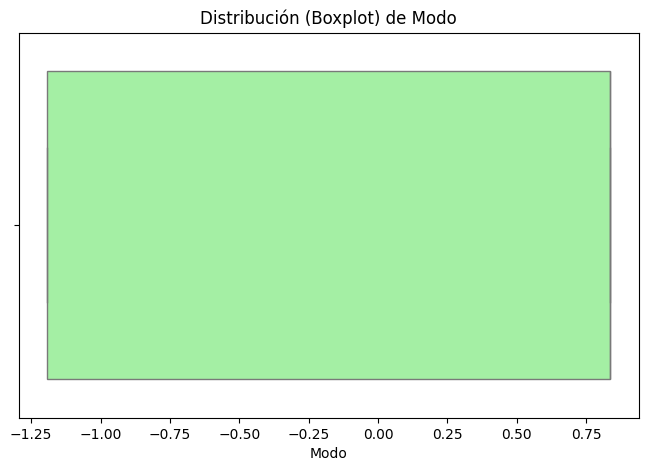

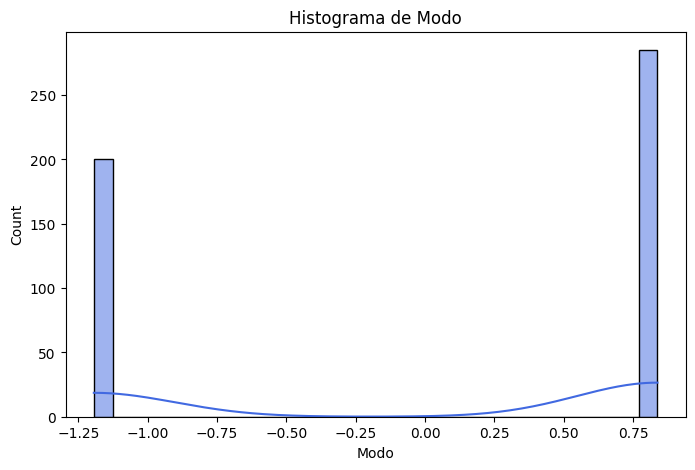


Generando visualizaciones para la columna: Valencia


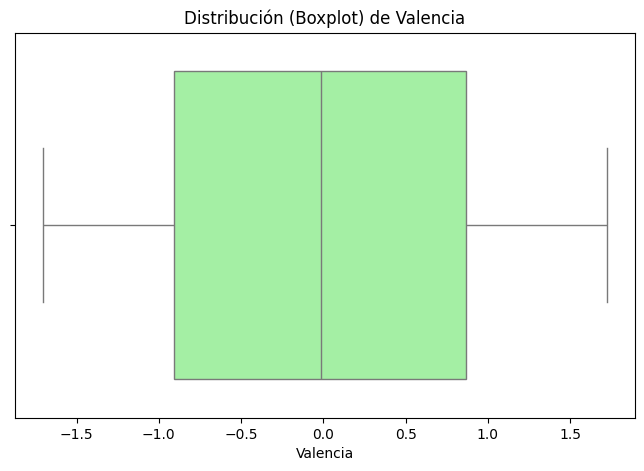

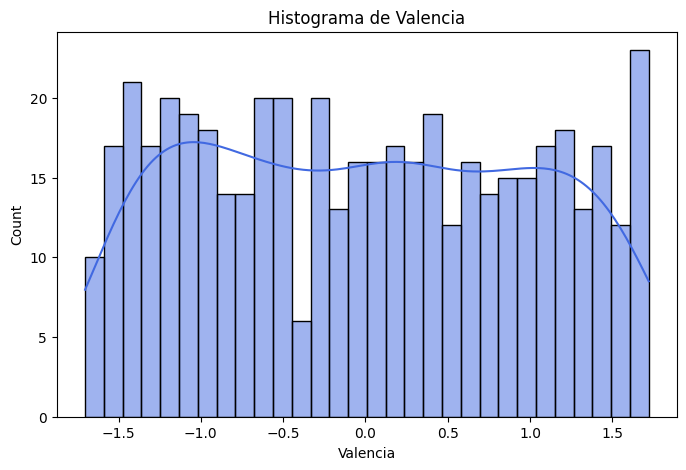


Generando visualizaciones para la columna: Género


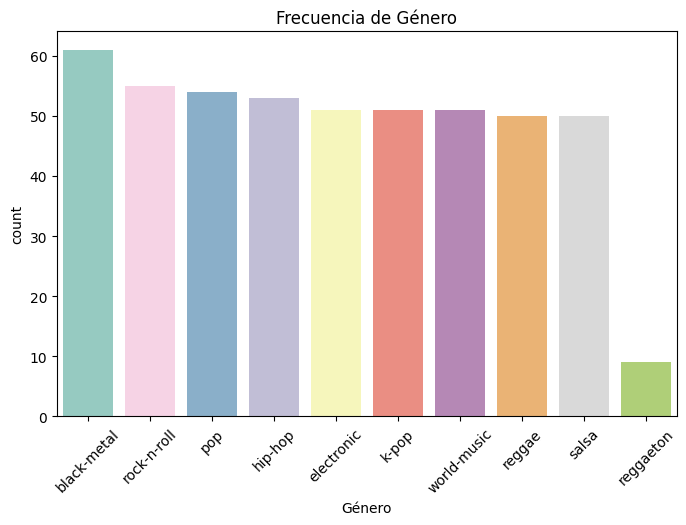

In [ ]:
for column in data.columns:
    print(f"\nGenerando visualizaciones para la columna: {column}")

    if data[column].dtype in ['int64', 'float64']:  #si son columnas numéricas
        #hacemos un boxplot
        plt.figure(figsize=(8, 5))
        sns.boxplot(x=data[column], color="palegreen")
        plt.title(f'Distribución (Boxplot) de {column}')
        plt.show()

        #ahora un histograma
        plt.figure(figsize=(8, 5))
        sns.histplot(data[column], kde=True, bins=30, color="royalblue")
        plt.title(f'Histograma de {column}')
        plt.show()

    elif data[column].dtype == 'object':  #si son categóricas o de texto
        #gráfica de barras para valores categóricos
        if data[column].nunique() <= 20:  #tomamos solo las primeras 20 categorías únicas
            plt.figure(figsize=(8, 5))
            sns.countplot(x=data[column], hue=data[column], order=data[column].value_counts().index, palette="Set3", legend=False)
            plt.title(f'Frecuencia de {column}')
            plt.xticks(rotation=45)
            plt.show()
        else:
            print(f"  La columna {column} tiene demasiados valores únicos para un gráfico de barras.")
    else:
        print(f"  Tipo de dato no manejado: {data[column].dtype}")





# Analizamos las correlaciones

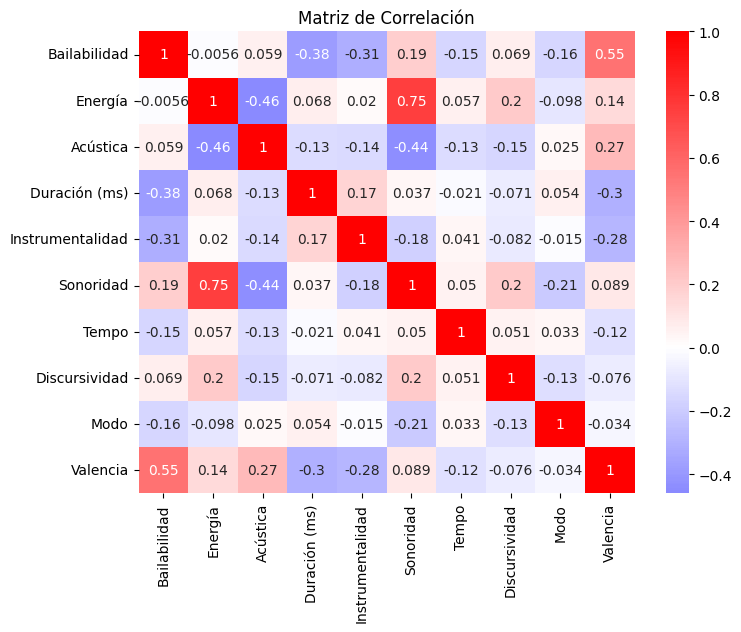

In [ ]:
#filtramos solo las columnas numéricas
columnas_numericas = data.select_dtypes(include=['int64', 'float64'])

#ahora sacamos de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(columnas_numericas.corr(), annot=True, cmap='bwr', center=0)
plt.title('Matriz de Correlación')
plt.show()


PCA y componentes principales

Varianza explicada por las componentes principales: [0.24771513 0.23921299 0.11714668]
Cargas de las variables en cada componente principal:
                        Bailabilidad   Energía  Acústica  Duración (ms)  \
Componente Principal 1      0.073586  0.586344 -0.465777       0.051140   
Componente Principal 2      0.550329  0.007677  0.225163      -0.404258   
Componente Principal 3     -0.010731 -0.181854 -0.022895      -0.428898   

                        Instrumentalidad  Sonoridad     Tempo  Discursividad  \
Componente Principal 1         -0.051519   0.591602  0.099658       0.261633   
Componente Principal 2         -0.393749   0.101048 -0.155795       0.032661   
Componente Principal 3         -0.108303  -0.135578  0.698154       0.482408   

                        Valencia  
Componente Principal 1  0.013809  
Componente Principal 2  0.540711  
Componente Principal 3 -0.179133  


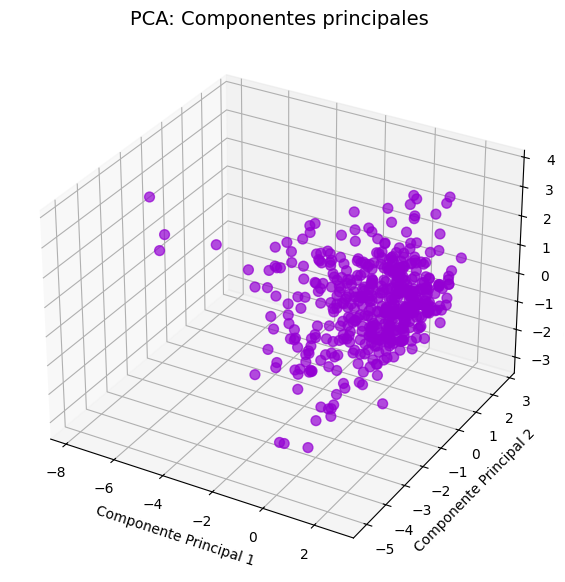

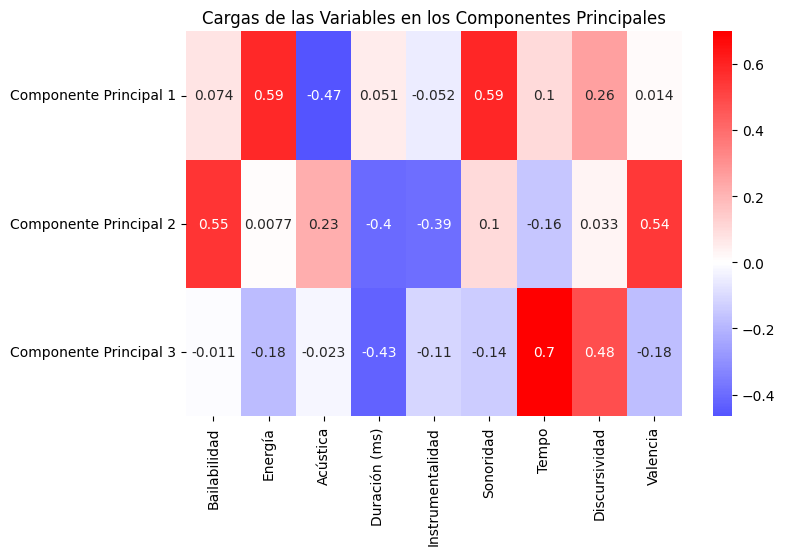

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#recordemos que debemos escalar los datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[['Bailabilidad', 'Energía', 'Acústica', 'Duración (ms)', 'Instrumentalidad', 'Sonoridad',
                                         'Tempo', 'Discursividad', 'Valencia']])

#aplicamos PCA para 3 componentes
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_scaled)
explained_variance = pca.explained_variance_ratio_
print(f"Varianza explicada por las componentes principales: {explained_variance}")

#obtenemos las cargas de las variables en las componentes principales
cargas = pd.DataFrame(pca.components_,
                      columns=['Bailabilidad', 'Energía', 'Acústica', 'Duración (ms)', 'Instrumentalidad', 'Sonoridad',
                               'Tempo', 'Discursividad', 'Valencia'],
                      index=['Componente Principal 1', 'Componente Principal 2', 'Componente Principal 3'])

#mostramos las cargas
print("Cargas de las variables en cada componente principal:")
print(cargas)

#visualizamos el PCA
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

#crear el scatterplot 3D
scatter = ax.scatter(
    pca_result[:, 0],  # Componente Principal 1
    pca_result[:, 1],  # Componente Principal 2
    pca_result[:, 2],  # Componente Principal 3
    c='darkviolet',
    alpha=0.7,
    s=50
)

#configuración de etiquetas y título
ax.set_title('PCA: Componentes principales', fontsize=14)
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')

# Mostrar el gráfico
plt.show()

#ahora con el heatmap de las cargas como heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(cargas, annot=True, cmap='bwr', center=0)
plt.title('Cargas de las Variables en los Componentes Principales')
plt.show()

Clusters

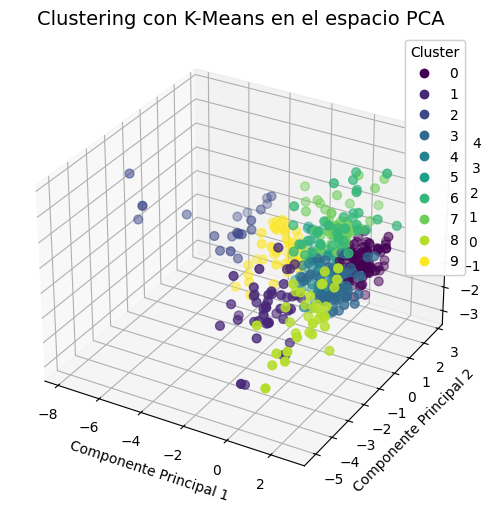

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

#realizamos el clustering usando las componentes principales
kmeans = KMeans(n_clusters=10, random_state=42)
data['Cluster'] = kmeans.fit_predict(pca_result)


#configuracion del gráfico 3D
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

#crear el scatterplot 3D
scatter = ax.scatter(
    pca_result[:, 0],
    pca_result[:, 1],
    pca_result[:, 2],
    c=data['Cluster'],
    cmap='viridis',
    s=40
)

# Etiquetas y título
ax.set_title('Clustering con K-Means en el espacio PCA', fontsize=14)
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')

#Cuadro de componentes
legend1 = ax.legend(
    *scatter.legend_elements(),
    title="Cluster",
    loc="upper right"
)
ax.add_artist(legend1)

plt.show()


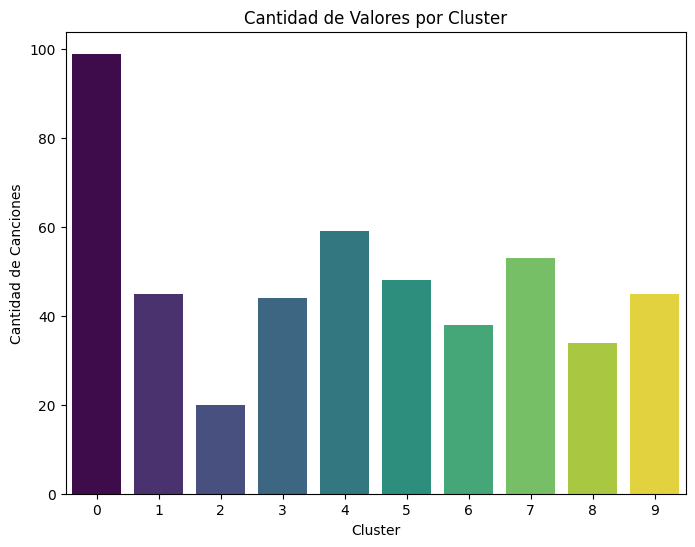

In [ ]:
#contamos cuantos valores hay en cada cluster
cluster_counts = data['Cluster'].value_counts().sort_index()

#graficamos cada cluster
plt.figure(figsize=(8, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, hue=cluster_counts.index, dodge=False, legend=False, palette='viridis')
plt.title('Cantidad de Valores por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Cantidad de Canciones')
plt.show()


Caracteristicas originales promedio por cluster:
         Bailabilidad   Energía  Acústica  Duración (ms)  Instrumentalidad  \
Cluster                                                                      
0            0.948223  0.772312  0.132894       0.247454          0.000254   
1           -1.093664  0.537598  0.101081       0.539140          0.339278   
2           -0.645898  0.193975  0.730572       0.205967          0.138106   
3           -0.648259  0.879118  0.036684       0.336313          0.069917   
4            0.111938  0.684942  0.236863       0.368990          0.041265   
5            0.456756  0.638490  0.477826       0.278803          0.002956   
6           -0.104611  0.674404  0.123009       0.245430          0.003139   
7            0.680260  0.644108  0.284275       0.203088          0.012334   
8           -1.510475  0.884566  0.007728       0.460979          0.479955   
9           -0.277088  0.418828  0.493031       0.282202          0.030947   

         Sonor

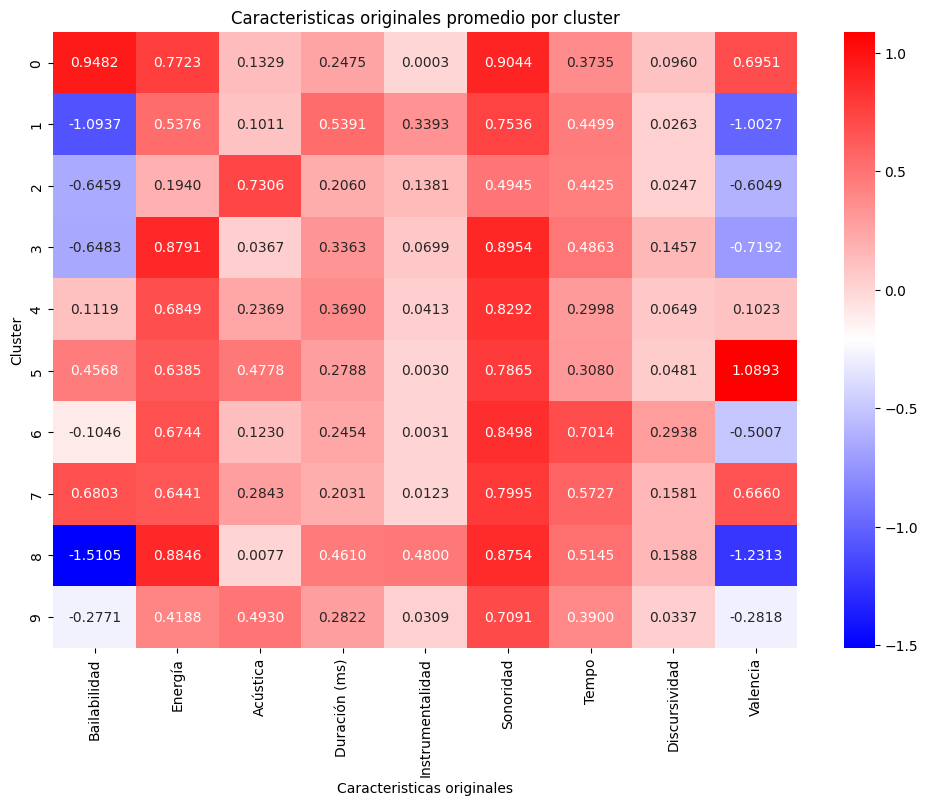

In [ ]:
#agrupamos los datos originales por cluster y calculamos el promedio
cluster_means_original = data.groupby('Cluster')[['Bailabilidad', 'Energía', 'Acústica', 'Duración (ms)',
                                                  'Instrumentalidad', 'Sonoridad', 'Tempo',
                                                  'Discursividad', 'Valencia']].mean()

#mostramos las caracteristicas originales promedio por cluster
print("Caracteristicas originales promedio por cluster:")
print(cluster_means_original)

#visualizamos las caracteristicas originales promedio por cluster usando un heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means_original, annot=True, fmt=".4f", cmap='bwr', cbar=True)
plt.title('Caracteristicas originales promedio por cluster')
plt.xlabel('Caracteristicas originales')
plt.ylabel('Cluster')
plt.show()


Género   black-metal  electronic  hip-hop  k-pop  pop  reggae  reggaeton  \
Cluster                                                                    
0                  0           4        6     31   16      28          6   
1                  6          10        0      1    3       0          0   
2                  1           3        0      0    1       0          0   
3                 25          10        0      2    2       2          0   
4                  0           8       12      2    7       3          1   
5                  0           2        2      1    3       9          1   
6                  1           4       15      3    4       5          1   
7                  0           2       14     10    8       2          0   
8                 28           4        0      0    0       0          0   
9                  0           4        4      1   10       1          0   

Género   rock-n-roll  salsa  world-music  
Cluster                                   
0

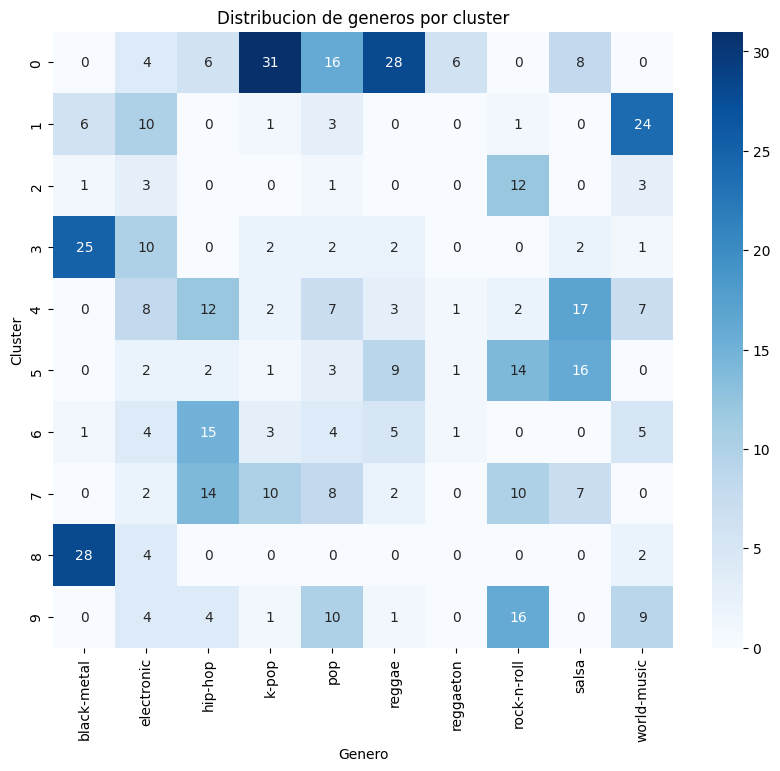

In [ ]:
#Conteo de generos por cluster
cluster_genre_counts = data.groupby(['Cluster', 'Género']).size().unstack(fill_value=0)
print(cluster_genre_counts)

plt.figure(figsize=(10, 8))
sns.heatmap(cluster_genre_counts, annot=True, fmt='d', cmap='Blues')
plt.title('Distribucion de generos por cluster')
plt.xlabel('Genero')
plt.ylabel('Cluster')
plt.show()
